In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as scs
from sklearn.linear_model import LinearRegression, Ridge, Lasso

np.random.seed(42)

%config InlineBackend.figure_format = 'retina'

## Regularized Regression

Wikipedia gives this peculiar definition for regularization:

> ...regularization is the process of adding information in order to solve an ill-posed problem...

We'll get back to this.

## A simple linear regression example

Let's define a simple linear relationship, with some small amount of noise.

In [2]:
np.random.seed(43)

x = np.random.uniform(0,10, size=5)
X = np.stack([x,x**2,x**3,x**4,x**5]).T
y = x+np.random.normal(scale=0.9,size=5)

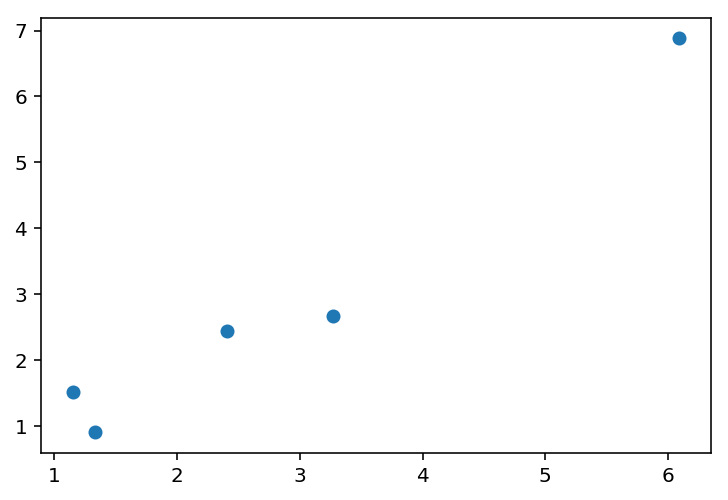

In [3]:
plt.scatter(x,y)

By using features for $x$, $x^2$, $x^3$, $x^4$, and $x^5$, we can fit the sample exactly.

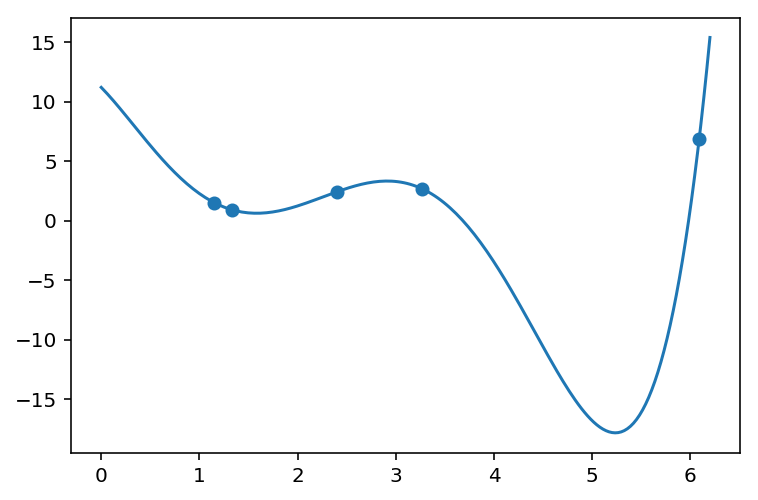

In [4]:
model = LinearRegression()
model.fit(X,y)

# ridge = Ridge()
# ridge.fit(X,y)

# lasso = Lasso()
# lasso.fit(X,y)

xspace = np.linspace(0,6.2,num=200)
Xspace = np.stack([xspace, xspace**2, xspace**3, xspace**4, xspace**5]).T
yspace = model.predict(Xspace)

plt.plot(xspace,yspace)
plt.scatter(x,y)

# plt.plot(xspace,ridge.predict(Xspace))
# plt.plot(xspace,lasso.predict(Xspace))

In [5]:
# ridge.coef_ #look away!
# ridge.intercept_

In [6]:
# lasso.coef_

The training loss of our model is:

In [7]:
model_error = ((y - model.predict(X))**2).sum()
model_error

6.395504525095762e-23

Nearly perfect. But obviously the model has a very high variance, which will hurt us on testing. How can we encode the intuition that the model is being silly?

Let's take a look at the model coefficients.

In [8]:
model.coef_

array([-8.42340487, -5.80493701,  7.19670896, -2.07209516,  0.17750473])

What if we say - they're **part of the problem**.

We might take a more holistic idea of "model badness" and sum in both the prediction error *and* some measure of the complexity.

Like - intuitively - big numbers are worse and absolute value are important so let's take the square of the coefficients:

In [9]:
model.coef_**2

array([7.09537496e+01, 3.36972936e+01, 5.17926198e+01, 4.29357834e+00,
       3.15079308e-02])

And then sum them

In [10]:
complexity_penalty = ( model.coef_**2 ).sum()
complexity_penalty

160.76874932044575

And then say our "holistic badness" is the model error plus this number: 

In [11]:
model_error + complexity_penalty

160.76874932044575

There. Now we have a number we can minimize during the training phase.

If we take the wheel and start training the model ourself in light of this new Holistic Badness, we might be tempted to just turn down one of the coefficients:

In [12]:
model.coef_

array([-8.42340487, -5.80493701,  7.19670896, -2.07209516,  0.17750473])

Let's just turn them down to these...handy...numbers.

In [13]:
model.coef_ = np.array( [ 0.04127873,  0.12910054,  0.18282266, -0.07967463,  0.00827166] )
model.intercept_ = 0.8454061169508842 #uh look away

In [14]:
model.coef_

array([ 0.04127873,  0.12910054,  0.18282266, -0.07967463,  0.00827166])

This improves our model complexity penalty ever so slightly.

In [15]:
complexity_penalty = ( model.coef_**2 ).sum()
complexity_penalty

0.0582114750129726

In [16]:
model_error = ((y - model.predict(X))**2).sum()
model_error

0.3269437291499049

In [17]:
complexity_penalty + model_error

0.38515520416287746

Hot diggity dog!!

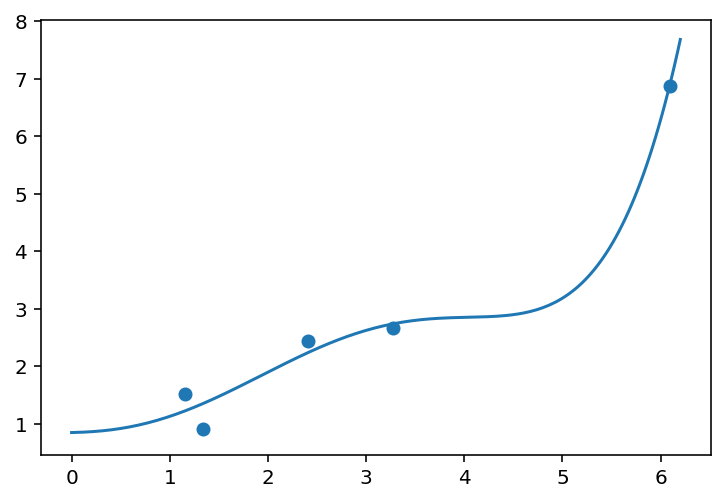

In [18]:
yspace = model.predict(Xspace)

plt.plot(xspace,yspace)
plt.scatter(x,y)

This reduction in complexity will increase bias but vastly decrease variance, resulting in lower expected error.

## The definition of regularization

> ...regularization is the process of adding information in order to solve an ill-posed problem...

The problem of polynomial regression was **ill-posed**; a faithful solution would not be what you're asking for. In fact, a full description of the problem is we want to balance training error and model complexity.

So we **added information** to the loss to reflect our intent. Specifically, we added a term to the loss that's the sum of the square of the coefficients.

Another way of looking at regularization is as a **restriction on the space of our parameters**, in order to embed some information about our desired solution. 

This is because computers are overly literal evil genies. Never ask a computer to eliminate all human suffering, because it'll just painlessly kill all humans. Instead **regularize** the problem by saying, "eliminate as much human suffering as possible without killing anyone."

## Ridge Regression

The previous example was a demonstration of **Ridge Regression**, which applies a penalty term to the loss proportional to the sum of the squares of the linear coefficients. Specifically, it minimizes:

$$\sum_{i=1}^{N}(y_i - \hat{\beta}_0 - \sum_{j=1}^{p}x_{ij}\hat{\beta}_j)^2 + \lambda \sum_{i=1}^{p}\hat{\beta}_i^2$$

Which you can read as

`prediction error + sum square coefficients`.

Note a couple of things:
* the intercept term $\beta_0$ is not penalized.
* the intensity of the complexity term is moduled by a $\lambda$ coefficient.
 * How would we choose this?
* This goes by many names. "L2 Regularization" is the general practice of applying a square-coefficient penalty to the model loss, not just in linear models.
* L2 regularization is differentiable; as a result, minimization doesn't ever push $\beta$ to 0.

In [19]:
ridge = Ridge()
ridge.fit(X,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [20]:
ridge.coef_

array([ 0.04127873,  0.12910054,  0.18282266, -0.07967463,  0.00827166])

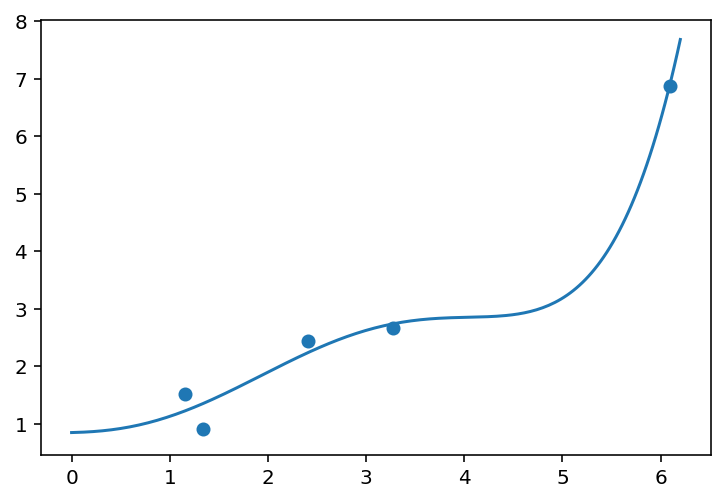

In [21]:
yspace = ridge.predict(Xspace)

plt.plot(xspace,yspace)
plt.scatter(x,y)

## Lasso Regression

Lasso regression is very similar to ridge regression, except it applies a sum absolute values term instead of a sum square term:

$$\sum_{i=1}^{N}(y_i - \hat{\beta}_0 - \sum_{j=1}^{p}x_{ij}\hat{\beta}_j)^2 + \lambda \sum_{i=1}^{p}|\hat{\beta}_i|$$

Which you can read as

`prediction error + sum absolute value coefficients`.

This is an instance of **L1 Regularization**. 

In this case the regularization function is *not* differentiable, one main consequence of which is that some coefficients might minimize to exactly 0. In a way, this can be considered a form of automatic feature selection.

In [22]:
lasso = Lasso(max_iter=10000) #to help with convergence
lasso.fit(X,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
lasso.coef_

array([ 0.        ,  0.        ,  0.        ,  0.02045927, -0.00270652])

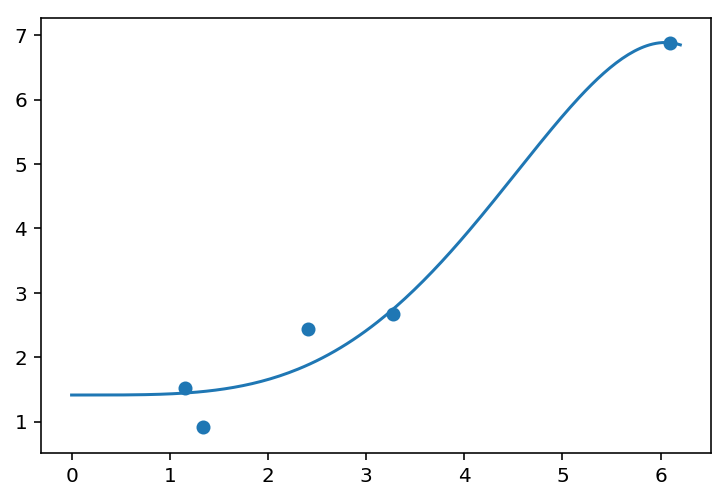

In [25]:
yspace = lasso.predict(Xspace)

plt.plot(xspace,yspace)
plt.scatter(x,y)

## Relationship with vanilla linear regression

In the case of both Ridge and Lasso regression, setting $\lambda$ to zero is equivalent to non-normalized regression.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


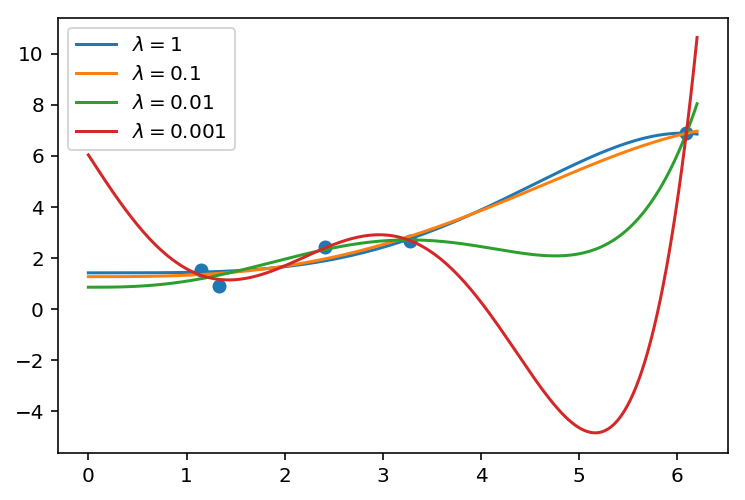

In [42]:
plt.scatter(x,y)

lasso = Lasso(alpha=1, max_iter=10000000) #to help with convergence
lasso.fit(X,y)
yspace = lasso.predict(Xspace)
plt.plot(xspace,yspace, label="$\lambda=1$")


lasso = Lasso(alpha=0.1, max_iter=10000000) #to help with convergence
lasso.fit(X,y)
yspace = lasso.predict(Xspace)
plt.plot(xspace,yspace, label="$\lambda=0.1$")

lasso = Lasso(alpha=0.01, max_iter=10000000) #to help with convergence
lasso.fit(X,y)
yspace = lasso.predict(Xspace)
plt.plot(xspace,yspace, label="$\lambda=0.01$")

lasso = Lasso(alpha=0.001, max_iter=10000000) #to help with convergence
lasso.fit(X,y)
yspace = lasso.predict(Xspace)
plt.plot(xspace,yspace, label="$\lambda=0.001$")

plt.legend()

You can think of $\lambda$ is decreasing the ductility of the linear model. This can help reduce overfitting. As always with model selection and hyperparameter turning, the choice will be driven by cross-validation.